In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [2]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/exchangeVBT"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "%Y-%m-%d %H:%M:%S")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [3]:
st = time.time()
fast_n = 50
slow_n = 200

close = AssetReadNode.make("Close", 0, exchange)
fast_ma = AssetScalerNode(
    exchange.registerObserver(SumObserverNode(close, fast_n)),
    AssetOpType.DIVIDE,
    fast_n
)
slow_ma = AssetScalerNode(
    exchange.registerObserver(SumObserverNode(close, slow_n)),
    AssetOpType.DIVIDE,
    slow_n
)
spread = AssetOpNode.make(fast_ma, slow_ma, AssetOpType.SUBTRACT)
spread_filter = ExchangeViewFilter(ExchangeViewFilterType.GREATER_THAN, 0.0, None)
exchange_view = ExchangeViewNode.make(exchange, spread, spread_filter)

allocation = AllocationNode.make(exchange_view)
strategy_node = StrategyNode.make(allocation, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0), True)
strategy.enableTracerHistory(TracerType.NLV)
hydra.run()

nlv = strategy.getHistory(TracerType.NLV)
returns = nlv[-1] / nlv[0] - 1

et = time.time()
print(f'Elapsed time: {1000*(et-st):.2f} ms')
print(f'Total return: {returns}')

Elapsed time: 0.74 ms


In [4]:
nlv = strategy.getHistory(TracerType.NLV)
timestamps = pd.to_datetime(exchange.getTimestamps())
returns = nlv[-1] / nlv[0] - 1
print("Returns: ", returns)

Returns:  4.851262581813547


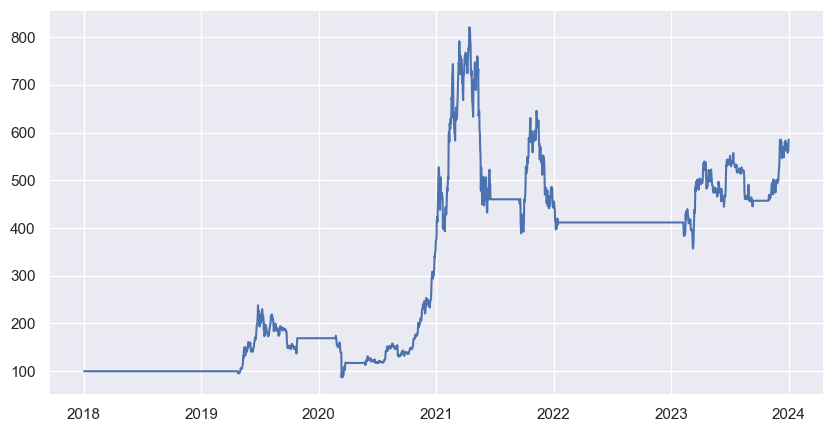

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(timestamps, nlv)